# **Notebook A.** Classification Model based on BOW [Bag-of-words] Approach
----

The most common and straightforward approach to text classification is to use a "Bag-of-Words" approach. This name implies that documents (in this case abstracts) are represented by indicators (counts) of what words occur in the document, and do not consider word order or context.

The goal is to represent each document based on the number of times each word occurs in them. We are going to use the *Scikit learn* (https://scikit-learn.org/stable/index.html) package, which has built-in functions that make this process very easy and straightforward.


**In this notebook**, we we will convert text documents to a Term-Document-Frequency Matrix and then compare different classification models to identify the best eperforming one.

Here is our workflow for this notebook:

- Step 1) Load the Data
- Step 2) Convert Text to TF-IDF Matrix
- Step 3) Perform Classification using Different Models
- Step 4) Compare Model Outputs

# A.1. Preamble: Load Packages
---

In [ ]:
# General Packages #
import os
import pandas as pd
import numpy as np

# Load TQDM to Show Progress Bars #
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

# Sklearn Packages #
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix

# Import SkLearn Classifiers #
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import Lasso, LassoCV, SGDClassifier, LinearRegression, LogisticRegression, RidgeCV, RidgeClassifierCV, HuberRegressor, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [ ]:
# Turn off warnings, just to avoid pesky messages that might cause confusion here
# Remove when testing your own code #
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Mount Personal Google Drive on own Machine -- You have to follow the link to log in #
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# A.2. Load Training Data ##
----------------

We are going to use the data on the Google drive. This is in a csv file, and so we are going to load the data as a dataframe, and then convert the main data (Text Ids, Indicator for Tech / Non-Tech, Text Abstract) from a Pandas DataFrame to a list (which is more easily used in later sections).

In [ ]:
# Change to Working Directory with Training Data #
os.chdir("/content/drive/MyDrive/Power-data-main/")

# Load Training Data #
file_path = 'Training Data/power_data.tsv'

# Read the TSV file
df = pd.read_csv(file_path, sep='\t')

# Extract the required columns: id, cleaned_abstract, and actual
IDs = np.array(df['id'].values.tolist())
Abstract_Text = df['abstract'].values.tolist()
Classes = df['actual'].values.tolist()

# A.3. Convert Text Data to Term-Document Frequency Matrix
----

We are going to use the built in sklearn tools to process the text. The idea is to construct a matrix represetantion of the data. The rows represent each document (abstract). The columns represent each word that occurs in any of the documents (corpus). The fields of the matrix (TF) represent how often each word occurs in each document.

This is illustrated below.


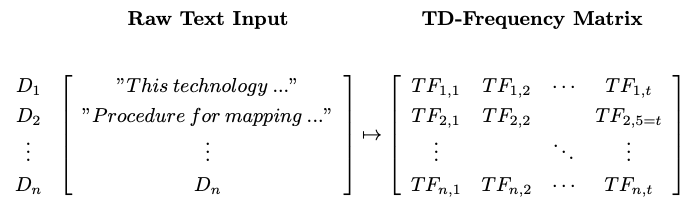




There are two functions that will perform this with relative ease:

- **CountVectorizer():** This provides a count for the number of times each word occurs in each document.

- **TfidfVectorizer():** This provides a measure of how often each word occurs, weighted by the overall likelihood that the word occurs in the corpus. This downweights the importance of words that occur frequently.


In [ ]:
# Define Model Parameters #

# Minimum Document Frequency -- Minimum number of times a word needs to occur to be considered #
MINDF = 10

# Maximum Document Frequency -- Maximum share of documents where a word needs to occur to be considered #
MAXDF = 0.5

# Maximum number of features we would want to consider -- ranked by most frequently occuring #
MF=2400

# NGrams -- Number of Word Pairs. Takes the form (Min, Max). E.g. (1, 2) means single words and word pairs #
NGrams = (1,3)

# Stopwords -- List of common words we want to omit (STOP_WORDS) #
import jieba
stopwords_path = 'Training Data/stopwords.txt'
with open(stopwords_path, 'r', encoding='utf-8') as f:
    STOP_WORDS = list(f.read().splitlines())

# 分词器函数，使用 jieba 分词
def jieba_tokenizer(text):
    tokens = jieba.lcut(text)
    return tokens

# Define Tokenizer -- This is a Custom Function that we use #
from textblob import TextBlob

# Define Textblob Tokenizer -- This Converts Words to Lowercase and Stems the keywords #
def textblob_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

In [ ]:
# Define Vectorizer #
vec = TfidfVectorizer(tokenizer=jieba_tokenizer,
            max_features= MF,
            max_df = MAXDF,
            stop_words = STOP_WORDS,
            ngram_range=(1, 3),
            )

In [ ]:
# Perform vectorizatiion and extract feature names #
Abstract_Vectors = vec.fit_transform(Abstract_Text)
FEATURENAMES = vec.get_feature_names_out()

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 3.021 seconds.
DEBUG:jieba:Loading model cost 3.021 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


# A.4 Define Set of Models to Compare #
----

We will be exploring the classification perfomance of different models based on text documents we have transformed using this embedding representation.


In [ ]:
# Define the Set of Classifiers and their parameters #

CLASSIFIERS = [
               ["Nearest Neighbors", KNeighborsClassifier()],
               ["Support Vector Classifier (RBF)", SVC()],
               ["Naive Bayes", MultinomialNB()],
               ["Logistic Regression", LogisticRegression()],
               ["Ridge Regression", RidgeClassifierCV()],
               ["Random Forest", RandomForestClassifier(n_estimators= 1000)],
               ["Decision Tree with Boosting", AdaBoostClassifier()],
               ["Decision Tree with Bagging", BaggingClassifier()],
               ["Multi Layer Perceptron", MLPClassifier(hidden_layer_sizes = (100,))],
               ["Gradient Boosting Classifier", GradientBoostingClassifier()],
               ['LASSO', LassoCV()],
               ['Linear Regression', LinearRegression()],
               ['Robust Regression', HuberRegressor()]
               ]


In [ ]:
# Number of Folds (Splits) for Cross Validation #
NUM_OF_SPLITS = 5

# Define whether you want to manually reweight the sample by oversampling the smaller class
Reweight = True

# Define arrays in which to store classification outputs #
RESULTS = []
Classified_Values =[]
Classified_Values_p =[]

# Loop Through Different Classifiers #
for CL in tqdm_notebook(CLASSIFIERS, desc = "Evaluating Classifiers"):

    # Extract Classifier Names & Model #
    name  = CL[0]
    Model = CL[1]

    # Define Arrays to store Actual, Predicted and Ids variables (Because we are shuffling them in next step) #
    y_actual = []
    y_predicted = []
    y_predicted_p = []

    id_s = []


    # Loop through K Folds and Repeat Cross Validation #

    KFoldSplitter = StratifiedKFold(n_splits = NUM_OF_SPLITS, shuffle = True, random_state = 1)

    for train_i, test_i in tqdm_notebook(KFoldSplitter.split(Abstract_Vectors, Classes),
                                  desc = 'Cross-Validating',
                                  leave = False,
                                  total = NUM_OF_SPLITS):

        # Select Rows in Data Based on Indexes [train_i, test_i]
        Y = np.array(Classes)

        train_X, test_X = Abstract_Vectors[train_i], Abstract_Vectors[test_i]
        train_y, test_y = Y[train_i], Y[test_i]
        Train_IDs, Test_IDs = IDs[train_i], IDs[test_i]

        # Reconstruct training data to ensure class are balanced approx. 50/50 (Reweight = True if yes) #
        temp_y = list(train_y)
        temp_X = train_X.todense().tolist()

        if Reweight == True:
            # Repeat up to three times. This is arbitrary, but should be cautios about doing it more often.
            # This current one needs only about 1.5 interations to balance the sample.
            for j in range(0,3,1):
                # Loop through eacb observation and add in positive values if the balance is not met
                for i in range(0, len(train_y), 1):
                    if (train_y[i] != 0) & (np.mean(temp_y) < 0.5) :
                        temp_y.append(temp_y[i])
                        temp_X.append(temp_X[i])
                    else:
                        continue

        # Train Model #
        Results = Model.fit(temp_X, temp_y)

        # Perform Prediction on Holdout Sample #
        y_pred = Model.predict(np.asarray(test_X.todense()))

        # Convert Continuous Predicted Values to 0/1 values #
        y_pred2 = []
        for y in y_pred:
            if y > 0.5:
                y_pred2.append(1)
            else:
                y_pred2.append(0)
        y_pred = y_pred2

        # Add to List with Final Results #
        y_actual = y_actual + list(test_y)
        y_predicted = y_predicted + y_pred
        id_s = id_s + list(Test_IDs)

        # We found that the Random Forest Model was the best performing classifier.
        # Therefore, we extracted the predicted probabilities as well so we could trace ROC curves.
        # We did not do it for all the models here as extracting the predicted values requires slightly
        # different commands for different models.

        if name == "Random Forest":

          y_pred_p = Model.predict_proba(np.asarray(test_X.todense()))

          y_pred2p = []
          for y in y_pred_p:
                  y_pred2p.append(y[1])
          y_pred_p = y_pred2p

          y_predicted_p = y_predicted_p + y_pred_p

    # ---------------------------------------------------------- #
    # This runs only after all of the folds have been classified #
    # ---------------------------------------------------------- #

    # Compuate the Share of Tech Texts #
    Share = np.round(np.mean(y_predicted), 3)

    # Calculate Model Performance Metrics #
    Accuracy = accuracy_score(y_actual, y_predicted)
    ROC = roc_auc_score(y_actual, y_predicted)
    Precision = precision_score(y_actual, y_predicted)
    Recall = recall_score(y_actual, y_predicted)
    F1 = f1_score(y_actual, y_predicted)
    CM = confusion_matrix(y_actual, y_predicted)

    # Round to 3 Decimal Places #
    #FN = np.round(CM[0][0]/CM[0].sum(), 3)
    #FP = np.round(CM[0][1]/CM[0].sum(), 3)
    #TN = np.round(CM[1][0]/CM[1].sum(), 3)
    #TP = np.round(CM[1][1]/CM[1].sum(), 3)

    FN = np.round(CM[0][0]/(CM[0][0] + CM[1][0]), 3)
    FP = np.round(CM[0][1]/(CM[0][1] + CM[1][1]), 3)
    TN = np.round(CM[1][0]/(CM[0][0] + CM[1][0]), 3)
    TP = np.round(CM[1][1]/(CM[0][1] + CM[1][1]), 3)


    # Add Classification Performance Metrics to List#
    RESULTS.append([name, Share, TP, FN, FP, TN,
                                          np.round(Accuracy, 3),
                                          np.round(ROC, 3),
                                          np.round(Precision, 3),
                                          np.round(Recall, 3),
                                          np.round(F1, 3)])

    # Add Classification Results to List #
    Classified_Values.append(list(zip(len(id_s)*[name],id_s, y_actual, y_predicted)))
    if name == "Random Forest":
      Classified_Values_p.append(list(zip(len(id_s)*[name],id_s, y_actual, y_predicted_p)))


Evaluating Classifiers:   0%|          | 0/13 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-Validating:   0%|          | 0/5 [00:00<?, ?it/s]

  # A.5. Output Classification Results #
----

Here we summarize the results regarding the classification performance of our models. Classification performance is based **only on the hold out** sample for all models.

In [ ]:
# Convert List of Model Performance Metrics to Dataframe #
RESULTS_TABLE = pd.DataFrame(RESULTS, columns = ["Name", "Share", "True-Positives",
                                                 "False-Negatives", "False-Positives",
                                                 "True-Negatives","Accuracy", "AUC",
                                                 "Precision", "Recall", "F1"] )
RESULTS_TABLE["Type"] = "Bag of Words"
RESULTS_TABLE = RESULTS_TABLE[["Name", "Type", "Share", "True-Positives",
                               "False-Negatives", "False-Positives",
                               "True-Negatives","Accuracy", "AUC",
                               "Precision", "Recall", "F1"]]

# Output Results #
RESULTS_TABLE.sort_values("Accuracy", ascending = False ).to_csv("./Output/Model Performance/BOW Model Classification Performance.csv")

# Display Results -- Out of Sample (Holdout) prediction -- Sorted by Accuracy #
RESULTS_TABLE.sort_values("Accuracy", ascending = False )

,Name,Type,Share,True-Positives,False-Negatives,False-Positives,True-Negatives,Accuracy,AUC,Precision,Recall,F1
5,Random Forest,Bag of Words,0.444,0.882,0.932,0.118,0.068,0.910,0.910,0.882,0.912,0.897
1,Support Vector Classifier (RBF),Bag of Words,0.425,0.898,0.918,0.102,0.082,0.909,0.907,0.898,0.890,0.894
3,Logistic Regression,Bag of Words,0.438,0.880,0.922,0.120,0.078,0.904,0.903,0.880,0.898,0.889
10,LASSO,Bag of Words,0.431,0.879,0.912,0.121,0.088,0.898,0.896,0.879,0.884,0.882
4,Ridge Regression,Bag of Words,0.437,0.871,0.914,0.129,0.086,0.895,0.894,0.871,0.887,0.879
9,Gradient Boosting Classifier,Bag of Words,0.418,0.880,0.895,0.120,0.105,0.889,0.885,0.880,0.857,0.869
8,Multi Layer Perceptron,Bag of Words,0.433,0.858,0.899,0.142,0.101,0.881,0.879,0.858,0.866,0.862
7,Decision Tree with Bagging,Bag of Words,0.412,0.875,0.883,0.125,0.117,0.880,0.875,0.875,0.840,0.857
6,Decision Tree with Boosting,Bag of Words,0.433,0.850,0.892,0.150,0.108,0.874,0.872,0.850,0.857,0.854
12,Robust Regression,Bag of Words,0.440,0.844,0.896,0.156,0.104,0.873,0.872,0.844,0.865,0.854


In [ ]:
# Output Classification Results for Training Dataset -- PREDICTED VALUES -- Out Of Sample (Holdout) Prediction #

for i in range(0,len(Classified_Values), 1):

  Temp = pd.DataFrame(  Classified_Values[i],
                        columns = ['Model', 'id', 'Actual', 'Predicted'] )

  if i == 0:
    name = Temp.head(1)['Model'][0]
    Temp = Temp[['id', 'Actual', 'Predicted']]
    Temp.columns = ['id', 'Actual', name]
    Final = Temp

  else:

    name = Temp.head(1)['Model'][0]
    Temp = Temp[['id', 'Predicted']]
    Temp.columns = ['id', name]

    Final = Final.merge(Temp, on = ['id'])

Final.to_csv("./Output/Classification Output/BOW Classification Results.csv")


Below, we output the predicted probabilities for the random forest model. We do this because it was the best performing model and we are going to use these predicted probabilities in later notebooks to generate classification performance metrics (e.g. ROC Curves).

In [ ]:
# Output Classification Results for Training Data -- PREDICTED PROBABILITIES FOR RANDOM FOREST MODEL ONLY -- Out Of Sample (Holdout) Prediction #

for i in range(0,len(Classified_Values_p), 1):

  Temp = pd.DataFrame(  Classified_Values_p[i],
                        columns = ['Model', 'id', 'Actual', 'Predicted'] )

  if i == 0:
    name = Temp.head(1)['Model'][0]
    Temp = Temp[['id', 'Actual', 'Predicted']]
    Temp.columns = ['id', 'Actual', name]
    Final = Temp

  else:

    name = Temp.head(1)['Model'][0]
    Temp = Temp[['id', 'Predicted']]
    Temp.columns = ['id', name]

    Final = Final.merge(Temp, on = ['id'])

Final.to_csv("./Output/Classification Output/Random Forest - BOW [Predicted Probabilities].csv")
